In [1]:
from google.colab import drive
drive.mount('/content/drive')
# カレントディレクトリの指定
import os
os.chdir('/content/drive/MyDrive/分析コンペ/05_ProbSpace/民泊サービスの宿泊料金予測/')

Mounted at /content/drive


In [31]:
import datetime
import pickle
import numpy as np
import pandas as pd
import warnings
import lightgbm as lgb

from glob import glob
from tqdm import tqdm
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from geopy.distance import geodesic

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from src.config import *
warnings.filterwarnings('ignore')

In [3]:
df_train = pd.read_csv('input/train_data.csv', parse_dates=[COL_LAST_REVIEW], dtype=DICT_DTYPES)
df_test = pd.read_csv('input/test_data.csv', parse_dates=[COL_LAST_REVIEW], dtype=DICT_DTYPES)
df_station = pd.read_csv('input/station_list.csv')

In [5]:
df_all = pd.concat([df_train, df_test]).reset_index(drop=True)

In [6]:
df_all.head()

,id,name,host_id,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365,y
0,1,KiyosumiShirakawa 3min|★SkyTree★|WIFI|Max4|Tre...,242899459,Koto Ku,35.68185,139.80310,Entire home/apt,1,55,2020-04-25,2.21,173,12008.0
1,2,Downtown Tokyo Iriya next to Ueno,308879948,Taito Ku,35.72063,139.78536,Entire home/apt,6,72,2020-03-25,2.11,9,6667.0
2,3,"Japan Style,Private,Affordable,4min to Sta.",300877823,Katsushika Ku,35.74723,139.82349,Entire home/apt,1,18,2020-03-23,3.46,288,9923.0
3,4,4 min to Shinjuku Sta. by train / 2 ppl / Wi-fi,236935461,Shibuya Ku,35.68456,139.68077,Entire home/apt,1,2,2020-04-02,1.76,87,8109.0
4,5,LICENSED SHINJUKU HOUSE: Heart of the action!,243408889,Shinjuku Ku,35.69840,139.70467,Entire home/apt,1,86,2020-01-30,2.00,156,100390.0


In [17]:
df_lon_lat = df_all[[COL_LATITUDE, COL_LONGITUDE]]

In [18]:
df_lon_lat.head()

,latitude,longitude
0,35.68185,139.80310
1,35.72063,139.78536
2,35.74723,139.82349
3,35.68456,139.68077
4,35.69840,139.70467


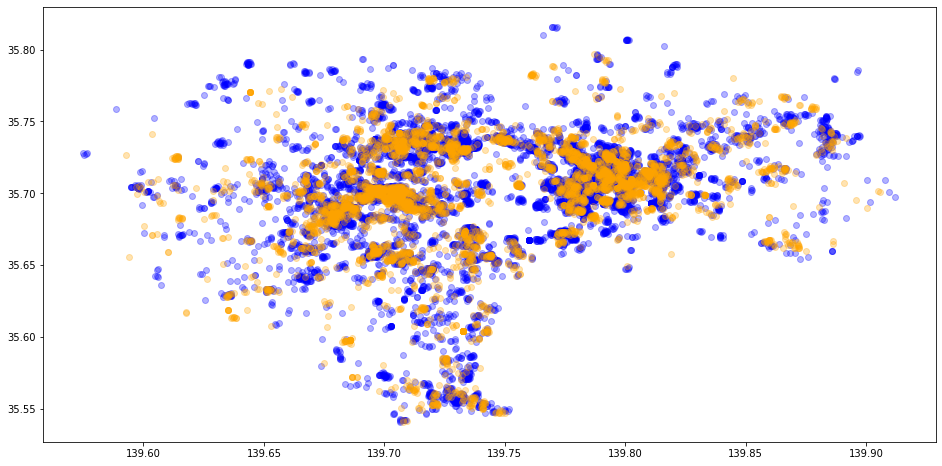

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
ax.scatter(df_train[COL_LONGITUDE], df_train[COL_LATITUDE], color='blue', alpha=0.3)
ax.scatter(df_test[COL_LONGITUDE], df_test[COL_LATITUDE], color='orange', alpha=0.3)
plt.show()

In [11]:
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit(df_lon_lat)
df_lon_lat['cluster'] = kmeans.labels_

In [12]:
df_lon_lat.head()

,latitude,longitude,cluster
0,35.68185,139.80310,7
1,35.72063,139.78536,3
2,35.74723,139.82349,3
3,35.68456,139.68077,2
4,35.69840,139.70467,9


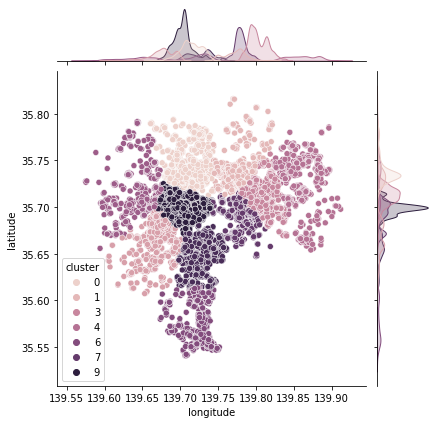

In [15]:
import seaborn as sns
sns.jointplot(data=df_lon_lat, x='longitude', y='latitude', hue='cluster')
plt.show()

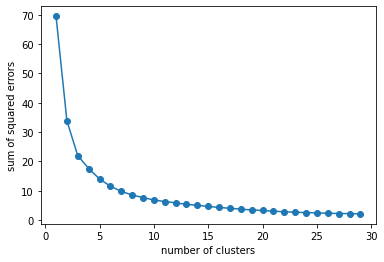

In [19]:
# エルボー法を実行
sum_of_squared_errors = []
for i in range(1, 30):
    model = KMeans(n_clusters=i, random_state=0, init='k-means++',)
    model.fit(df_lon_lat)
    sum_of_squared_errors.append(model.inertia_)  # 損失関数の値を保存

plt.plot(range(1, 30), sum_of_squared_errors, marker='o')
plt.xlabel('number of clusters')
plt.ylabel('sum of squared errors')
plt.show()

In [20]:
gm = GaussianMixture(n_components=10, random_state=0).fit(df_all[[COL_LATITUDE, COL_LONGITUDE]])
pred = gm.predict_proba(df_all[[COL_LATITUDE, COL_LONGITUDE]])
df_cluster = pd.DataFrame(pred, columns=[f'proba_cluster_{i+1}' for i in range(pred.shape[1])])
#df_all = pd.concat([df_all, df_cluster], axis=1)

In [21]:
df_cluster.head()

,proba_cluster_1,proba_cluster_2,proba_cluster_3,proba_cluster_4,proba_cluster_5,proba_cluster_6,proba_cluster_7,proba_cluster_8,proba_cluster_9,proba_cluster_10
0,3.751721e-33,6.477673e-09,4.318068e-49,7.919712e-01,3.440517e-09,3.176402e-53,1.803509e-01,0.001071,2.226841e-02,0.004339
1,3.814709e-06,1.209643e-01,3.391169e-24,8.514512e-01,1.398213e-10,3.513248e-86,8.445175e-03,0.015479,9.509122e-11,0.003657
2,1.794236e-08,2.069074e-20,1.123546e-37,7.079735e-03,2.433612e-17,1.639642e-236,9.631256e-01,0.021310,3.172316e-19,0.008484
3,3.710030e-25,1.116984e-133,8.895993e-01,6.711302e-18,1.022782e-04,3.867571e-12,7.745261e-09,0.002138,2.827300e-04,0.107878
4,4.447044e-14,1.098610e-81,1.276573e-02,2.705166e-11,1.642593e-05,9.734604e-01,8.336497e-08,0.001746,3.543478e-07,0.012011


In [26]:
df_cluster.shape

(14986, 10)

In [27]:
df_train_gaussianmixture = df_cluster[:df_train.shape[0]].reset_index(drop=True)
df_test_gaussianmixture = df_cluster[df_train.shape[0]:].reset_index(drop=True)

In [29]:
df_train_gaussianmixture.to_csv('input/train_data_gaussianmixture.csv', index=False)
df_test_gaussianmixture.to_csv('input/test_data_gaussianmixture.csv', index=False)

In [30]:
def get_distance(df):
    list_distance = []
    for i in tqdm(range(len(df))):
        list_tmp = []
        coordinate = (df.loc[i, COL_LATITUDE], df.loc[i, COL_LONGITUDE])
        for j in range(len(df)):
            compare_coordinate = (df.loc[j, COL_LATITUDE], df.loc[j, COL_LONGITUDE])
            list_tmp.append(geodesic(coordinate, compare_coordinate).km)
        list_distance.append(list_tmp)
    return list_distance

In [32]:
list_distance = get_distance(df_all)

  0%|          | 5/14986 [00:21<18:07:55,  4.36s/it]


KeyboardInterrupt: ignored